<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Codealong

_Authors: Joseph Nelson (DC)_

---

> **Note:** this codealong lesson is intended to come after the slideshow presentation and be guided in detail by the instructor.

### Learning Objectives
- Practice using statsmodels' timeseries tools on bus ridership data.
- Plot the decomposition of the timeseries.
- Conduct a Dickey-Fuller test for stationarity and plot the results.
- Perform first and second order differencing, as well as seasonal differencing on data.
- Plot ACF and PACF with European retail data.
- Examine the use of SARIMAX state-space modeling for advanced timeseries forecasting.

### Lesson Guide
- [Statsmodels timeseries tools](#statsmodels-timeseries-tools)
- [Bus ridership data](#bus-ridership-data)
	- [Clean the data](#clean-the-data)
	- [Create a date index for the data](#create-a-date-index-for-the-data)
- [Plot the riders across months](#plot-the-riders-across-months)
- [Decompose the timeseries and plot](#decompose-the-timeseries-and-plot)
- [Dickey-Fuller test of stationarity](#dickey-fuller-test-of-stationarity)
	- [Perform test on the first-differenced timeseries](#perform-test-on-the-first-differenced-timeseries)
	- [Perform test on *seasonal*-differenced timeseries](#perform-test-on-seasonal-differenced-timeseries)
	- [Perform a test on the first seasonal differenced timeseries](#perform-a-test-on-the-first-seasonal-differenced-timeseries)
- [Load the European retail data](#load-the-european-retail-data)
- [Create autocorrelation and partial autocorrelation plots](#create-autocorrelation-and-partial-autocorrelation-plots)
	- [Take a second-order difference of the retail timeseries](#take-a-second-order-difference-of-the-retail-timeseries)
- [Seasonal ARIMA with additional predictors (SARIMAX)](#seasonal-arima-with-additional-predictors-sarimax)
	- [Forecast using the SARIMAX model](#forecast-using-the-sarimax-model)
- [Additional resources](#additional-resources)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

<a id="statsmodels-timeseries-tools"></a>
## Statsmodels timeseries tools
---

Statsmodels (the dev version), has a wide variety of reliable timeseries analysis tools. We will start off by loading the autocorrelation and partial autocorrelation functions, as well as a function to decompose timeseries.

In [2]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/jmpounders/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id="bus-ridership-data"></a>
## Bus ridership data
---

We are going to play around with some Portland, OR bus data. Load in the bus data below and check it out.

<a id="clean-the-data"></a>
### Clean the data

In [3]:
# data https://datamarket.com/data/set/22w6/portland-oregon-average-monthly-bus-ridership-100-january-1973-through-june-1982-n114#!ds=22w6&display=line
bus = pd.read_csv('../datasets/portland-oregon-average-monthly-.csv', index_col=0)
bus.index.name=None
bus.reset_index(inplace=True)
bus.head()

,index,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [4]:
bus.tail()

,index,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
111,1969-04,1432
112,1969-05,1394
113,1969-06,1327
114,NaN,NaN
115,Portland Oregon average monthly bus ridership ...,n=114


There are a couple of bad rows. Get rid of them.

In [5]:
bus.drop(bus.index[115], inplace=True)
bus.drop(bus.index[114], inplace=True)

Make the riders column an integer:

In [6]:
# riders
bus.columns= ['index','riders']
# df['riders'] = df.riders.apply(lambda x: int(x)*100)
bus['riders'] = bus.riders.apply(lambda x: int(x))
bus.riders.head()

0    648
1    646
2    639
3    654
4    630
Name: riders, dtype: int64

<a id="create-a-date-index-for-the-data"></a>
### Create a date index for the data

We are going to create an artificial date index using the [`relativedelta`](http://dateutil.readthedocs.io/en/stable/relativedelta.html) function as exemplified below. We will simply start at 1973-01-01 and iterate up a month at a time.

In [7]:
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)] # edited to 115
bus['index'] =date_list
bus.set_index(['index'], inplace=True)
bus.index.name=None

print(len(date_list))  # check
print(len(bus.index))   # check

114
114


In [8]:
bus.head()

,riders
1973-01-01,648
1973-02-01,646
1973-03-01,639
1973-04-01,654
1973-05-01,630


<a id="plot-the-riders-across-months"></a>
## Plot the riders across months
---


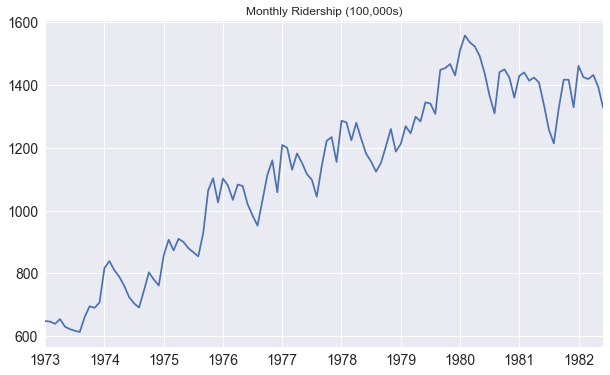

In [9]:
bus.riders.plot(figsize=(10,6), title= 'Monthly Ridership (100,000s)', fontsize=14)

<a id="decompose-the-timeseries-and-plot"></a>
## Decompose the timeseries and plot
---

Using the `seasonal_decompose` function, we can break the timeseries into its constituent parts.

Use the function on the riders data with a frequency of 12, then plot the data.

> **Hint:** The decomposition object from `seasonal_decompose` has a `.plot` function like with pandas dataframes

In [10]:
bus.dtypes

riders    int64
dtype: object

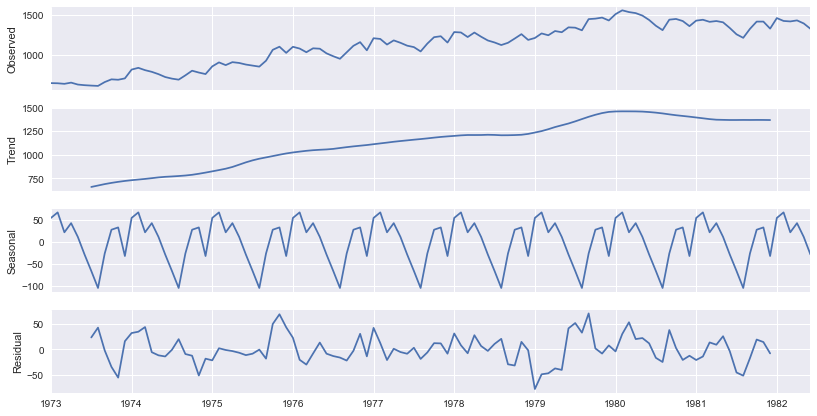

In [11]:
decomposition = seasonal_decompose(bus.riders, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)

**Plot just the seasonal component.**

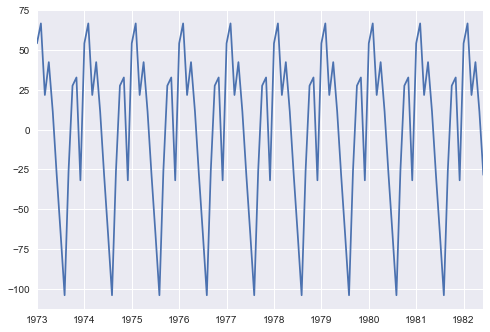

In [12]:
# grab just one graphic doing the following:
seasonal = decomposition.seasonal 
seasonal.plot()

<a id="dickey-fuller-test-of-stationarity"></a>
## Dickey-Fuller test of stationarity
---

[We can perform an (augmented) Dickey-Fuller test of stationarity](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to evaluate whether or not the timeseries is stationary.


In [13]:
# define Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 


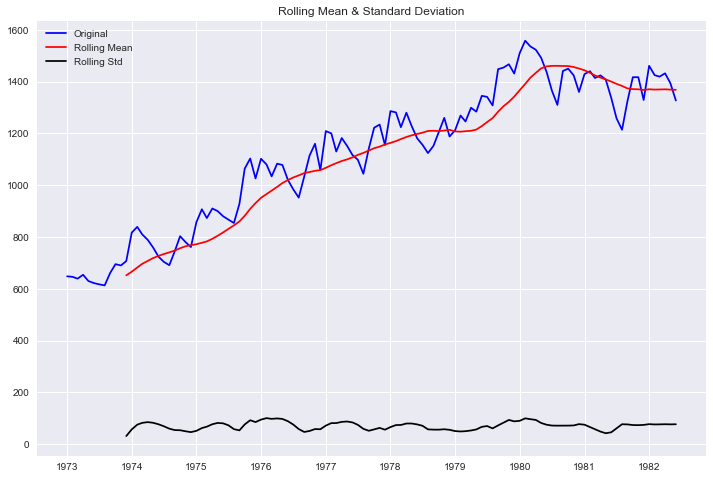

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [14]:
# perform test
test_stationarity(bus.riders)

<a id="perform-test-on-the-first-differenced-timeseries"></a>
### Perform test on the first-differenced timeseries

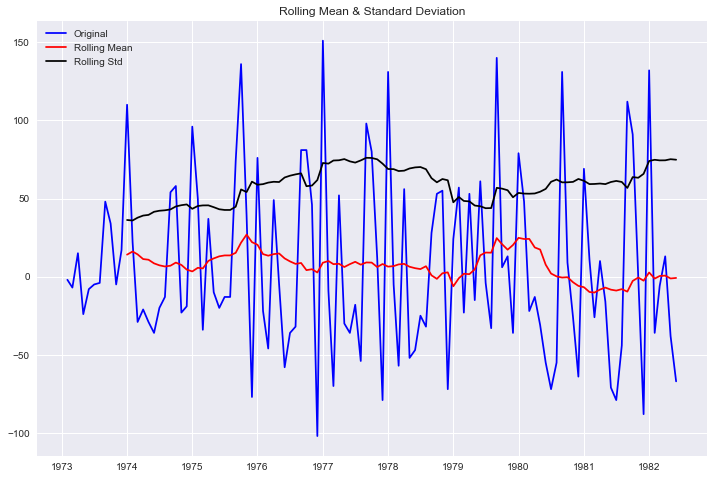

Results of Dickey-Fuller Test:
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [15]:
# first difference
bus['first_difference'] = bus.riders - bus.riders.shift(1)  
test_stationarity(bus.first_difference.dropna(inplace=False))

<a id="perform-test-on-seasonal-differenced-timeseries"></a>
### Perform test on *seasonal*-differenced timeseries

Where the season will be a year's difference (12 months).

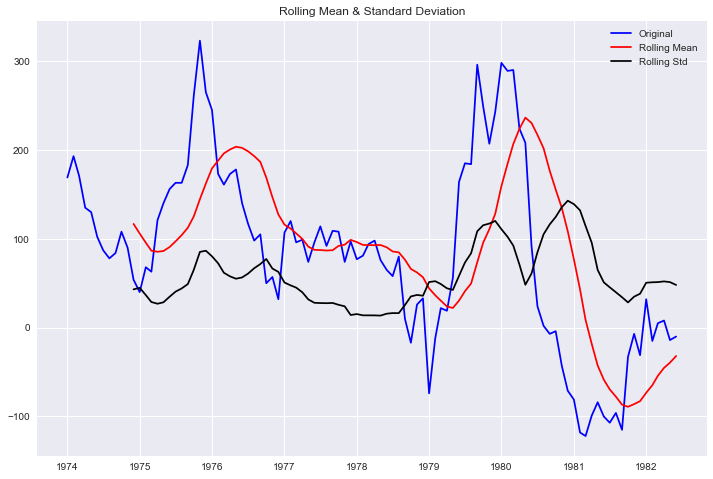

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [16]:
# seasonal difference
bus['seasonal_difference'] = bus.riders - bus.riders.shift(12)  
test_stationarity(bus.seasonal_difference.dropna(inplace=False))

<a id="perform-a-test-on-the-first-seasonal-differenced-timeseries"></a>
### Perform a test on the first seasonal differenced timeseries

At this point we can see that we have a significant result!

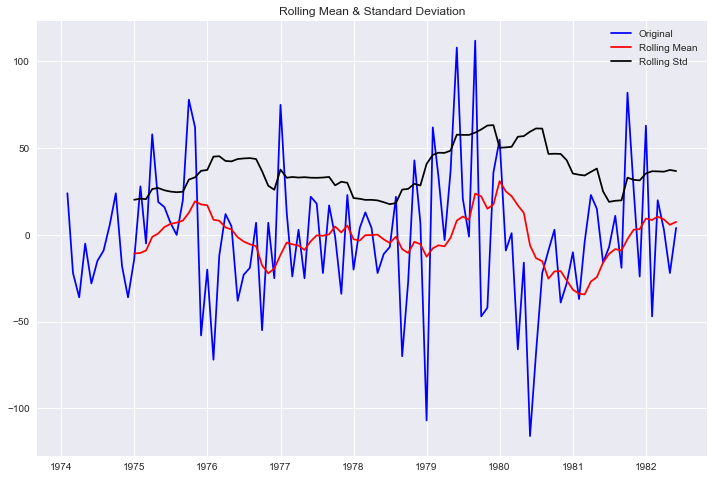

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [17]:
# first seasonal difference
bus['seasonal_first_difference'] = bus.first_difference - bus.first_difference.shift(12)  
test_stationarity(bus.seasonal_first_difference.dropna(inplace=False))

<a id="load-the-european-retail-data"></a>
## Load the European retail data
---

Make the index the year and create an initial plot of the data.

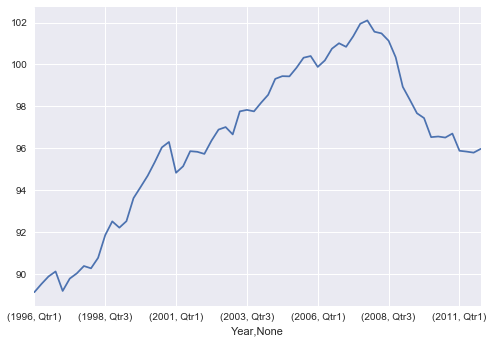

In [18]:
df = pd.read_csv('../datasets/euretail.csv')
df = df.set_index(['Year'])
df.head()
df.stack().plot()

<a id="create-autocorrelation-and-partial-autocorrelation-plots"></a>
## Create autocorrelation and partial autocorrelation plots 
---

Create a first-differenced timeseries of the retail data, then use `plot_acf` and `plot_pacf`.

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

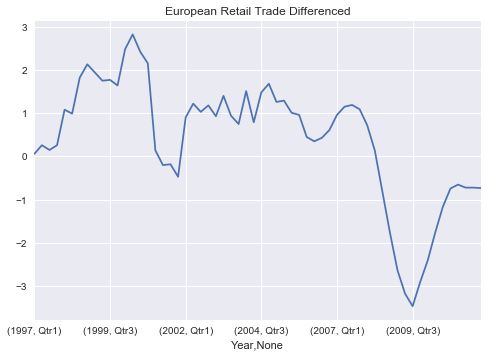

In [20]:
# regular diff
diff0 = df.stack().diff(periods=4)[4:]
diff0.plot(title='European Retail Trade Differenced')

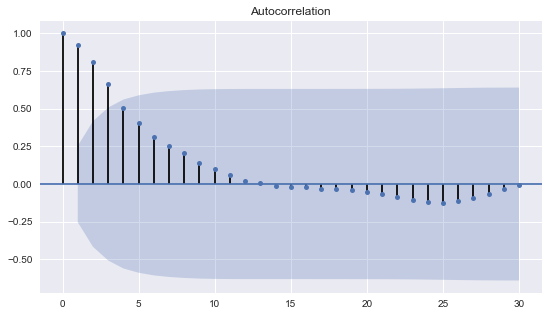

In [21]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(diff0, lags=30, ax=ax)
plt.show()

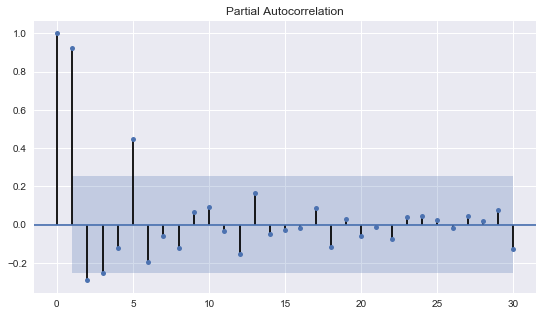

In [22]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(diff0, lags=30, ax=ax)
plt.show()

<a id="take-a-second-order-difference-of-the-retail-timeseries"></a>
### Take a second-order difference of the retail timeseries

Plot the ACF and PACF again with the second-order differenced series.

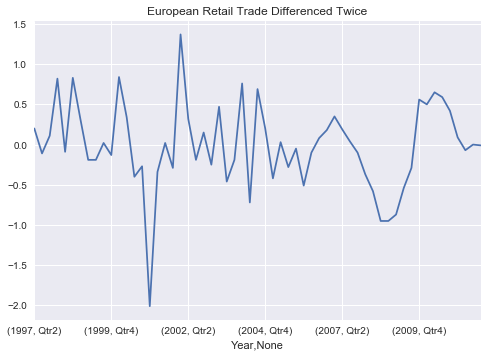

In [23]:
# additional diff
diff1 = diff0.diff()[1:]
diff1.plot(title='European Retail Trade Differenced Twice')


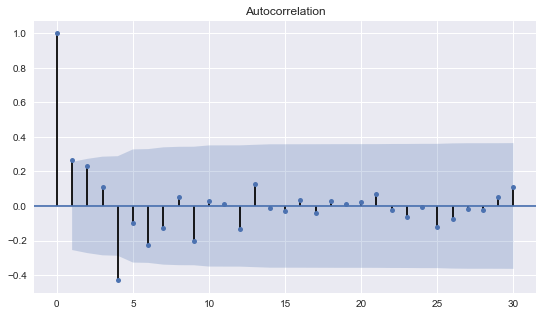

In [24]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(diff1, lags=30, ax=ax)
plt.show()

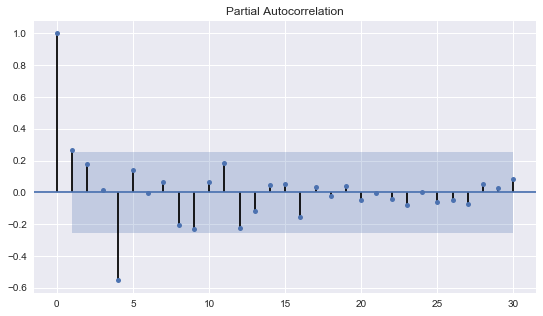

In [25]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(diff1, lags=30, ax=ax)
plt.show()

<a id="seasonal-arima-with-additional-predictors-sarimax"></a>
## Seasonal ARIMA with additional predictors (SARIMAX)
---

The [SARIMAX model](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) is an advanced state space model that allows us to build a seasonal ARIMA and also take into account the effects of other predictors.

The granular details of SARIMAX are beyond the scope of this walkthrough, but we can build a model and use it to forecast as an example of the powerful timeseries analysis capabilities that statsmodels contains.

In [26]:
import statsmodels.api as sm
data = df.stack().values
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,1,4))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -34.680
Date:                           Wed, 15 Nov 2017   AIC                             75.360
Time:                                   13:18:22   BIC                             81.837
Sample:                                        0   HQIC                            77.912
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2901      0.155      1.869      0.062      -0.014       0.594
ma.S.L4       -0.6909      0.132     -5.240

**Plot the residuals of the SARIMAX model.**

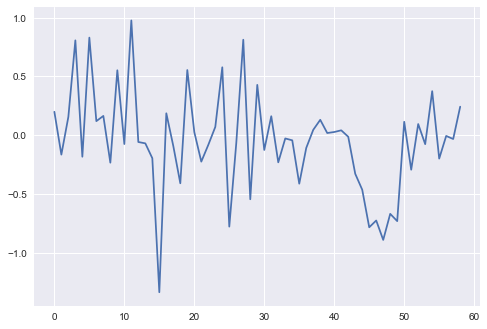

In [27]:
# Don't plot the first 5 values, to account for data loss when differencing (d=1 + D=5)
residuals = results.resid[5:]
plt.plot(residuals)

**Plot the ACF and PACF of the residuals.**

What should we be expecting from the ACF and PACF of our residuals if the model is good?

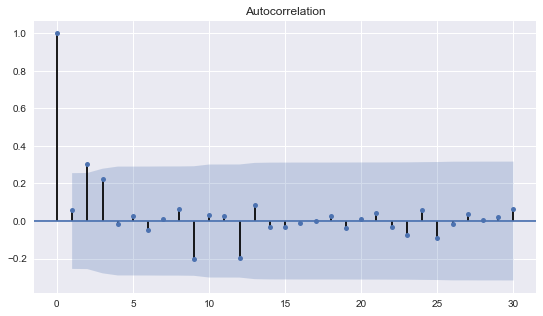

In [28]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax)
plt.show()

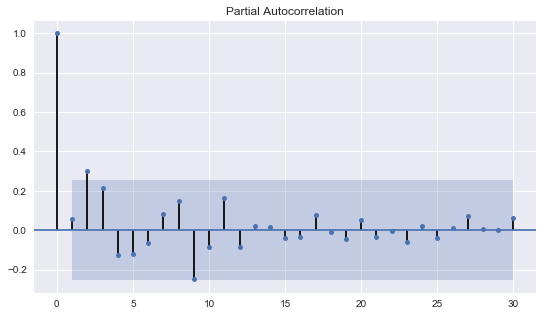

In [29]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=30, ax=ax)
plt.show()

**Increase the order of the SARIMAX model.**

How do the results change?

In [30]:
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,2), seasonal_order=(0,1,1,4))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 4)   Log Likelihood                 -32.809
Date:                           Wed, 15 Nov 2017   AIC                             73.618
Time:                                   13:18:32   BIC                             82.254
Sample:                                        0   HQIC                            77.020
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2307      0.157      1.471      0.141      -0.077       0.538
ma.L2          0.2497      0.115      2.171

In [32]:
# AIC is slightly lower, so maybe a better choice.

<a id="forecast-using-the-sarimax-model"></a>
### Forecast using the SARIMAX model

Statsmodels result objects from SARIMAX have a `.forecast` function that can use the state space model to predict out to future timepoints.

Forecast 12 additional timepoints and plot them.

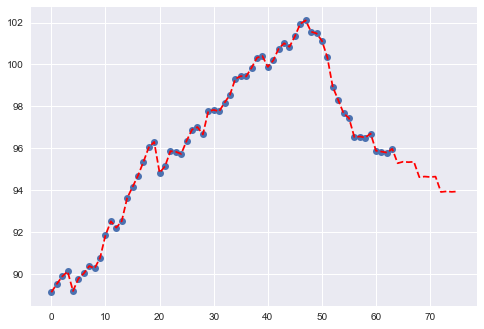

In [31]:
# forecasting
res = model.fit()
preds = res.forecast(12)
fcast = np.concatenate((data, preds), axis=0)

plt.figure();
plt.plot(data, 'o' , fcast, 'r--');

<a id='additional-resources'></a>
## Additional resources
---

+ A soft introduction to [Akaike Information Criteria](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)
+ A [video introduction](https://www.youtube.com/watch?v=YkD7ydzp9_E) to AIC
+ [Wikipedia AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)
+ A Seasonal ARIMA [code-along](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) from statsmodels
+ An excellent [blog code-along](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) to Seasonal ARIMA + [iPython noteback](https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb)
+ Duke's breakdown of [ACF and PACF](http://people.duke.edu/~rnau/411arim3.htm)
+ Duke's breakdown of available [stationarity transformations](http://people.duke.edu/~rnau/whatuse.htm)
+ An 35min [video econometric](https://www.youtube.com/watch?v=Y2khrpVo6qI) breakdown of ARIMA
+ [Wikipedia Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
+ Stats Exchange breakdown of [Augmented Dickey-Fuller](http://stats.stackexchange.com/questions/44647/which-dickey-fuller-test-should-i-apply-to-a-time-series-with-an-underlying-mode)
+ Compliments of Jonathan: a walk-through of selecting pdq from [Duke](http://people.duke.edu/~rnau/411arim.htm)
+ Compliments of Jonathan pt 2: big data analytics with ARIMA [case study](http://sda-pakdd2014.weebly.com/uploads/2/4/0/8/24088081/7w12.pdf)
+ BONUS! Checkout [Granger Causality tests](https://en.wikipedia.org/wiki/Granger_causality)
